# Data Science Analyze and Present A/B Test Results

X company recently introduced a new bidding type, “average bidding”, as an alternative to its exisiting bidding
type, called “maximum bidding”. One of our clients, X.com, has decided to test this new feature
and wants to conduct an A/B test to understand if average bidding brings more conversions than maximum
bidding.

In this A/B test, X.com randomly splits its audience into two equally sized groups, e.g. the test
and the control group. A X company ad campaign with “maximum bidding” is served to “control group” and
another campaign with “average bidding” is served to the “test group”.

The A/B test has run for 1 month and X.com now expects you to analyze and present the results
of this A/B test.



##### You should answer the following questions in this notebook

1. How would you define the hypothesis of this A/B test?
2. Can we conclude statistically significant results?
3. Which statistical test did you use, and why?
4. Based on your answer to Question 2, what would be your recommendation to client?


##### Hints:

1. The customer journey for this campaign is:
    1. User sees an ad (Impression)
    2. User clicks on the website link on the ad (Website Click)
    3. User makes a search on the website (Search)
    4. User views details of a product (View Content)
    5. User adds the product to the cart (Add to Cart)
    6. User purchases the product (Purchase)
2. Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.
3. If you see trends, anomalies or other patterns, discuss these in your notebool.
4. You can make assumptions if needed.


**Note: I translated also Turkish language**

## 1. Import libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import shapiro
import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

## 2. Functions

In [6]:
def read_data() :
    """
      Reads and loads control and test group data from an Excel file.
    - **Control group** (Maximum Bidding): Existing campaign data.
    - **Test group** (Average Bidding): Data from the new bidding strategy.
    The function removes rows with NaN values that originated from notes in the Excel file for the control group.
    """
    #Maximum Bidding(Existing)
    control = pd.read_excel("../input/ab-test-dataset/AB_Case_Study.xlsx", sheet_name="Control Group")
    #Average Bidding(New)
    test = pd.read_excel("../input/ab-test-dataset/AB_Case_Study.xlsx", sheet_name="Test Group")

    #control dataframeinde exceldeki not kısmından gelen NaN value içeren indexler uçuruldu
    control.drop(control.index[[30,31]], inplace = True)

    return control, test

def get_catvar(df) :
    """
    Identifies and extracts categorical variables from a DataFrame.
    - Returns the original DataFrame, a DataFrame of only categorical variables, and the names of the categorical columns.
    """
    cat_col = [col for col in df.columns if ( (df[col].dtype == 'object') | (df[col].dtype == 'bool'))]
    kat_df = pd.DataFrame(df[cat_col], index = df[cat_col].index)
    return df, kat_df, cat_col

def get_numvar(cat_col,df):
    """
    Identifies and extracts numerical variables from a DataFrame, excluding those specified as categorical.
    - Returns the original DataFrame, a DataFrame of only numerical variables, and the names of the numerical columns.
    """
    num_col = [c for c in df.columns if c not in cat_col]
    num_df = pd.DataFrame(df[num_col], index = df[num_col].index)
    return df, num_df, num_col

def fill_NaNValue(num_control) :
    """
    Implements K-Nearest Neighbors Imputation to fill in missing values in numerical columns of the control group.
    - Returns a DataFrame with missing values filled.
    """
    cols = num_control.columns
    imputer = KNNImputer(n_neighbors=8)
    num_control = imputer.fit_transform(num_control)
    num_control=pd.DataFrame(num_control,columns=cols)
    return num_control

def convert_datatype(control):
    """
      Converts specified columns in the control group DataFrame to integer data types.
    - This is important for ensuring data consistency and correctness in calculations.
    """
    control = control.astype({'# of Impressions' : 'int64',
                        'Reach': 'int64',
                        '# of Website Clicks' : 'int64',
                        '# of Searches': 'int64',
                        '# of View Content': 'int64',
                        '# of Add to Cart': 'int64',
                        '# of Purchase' : 'int64'})
    return control

def outliers(control, test):
    """
    Detects and handles outliers in the test group data using Local Outlier Factor (LOF).
    - Prints scores of the detected outliers and modifies extreme outlier values based on a specified threshold.
    """
    clf= LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(test.iloc[:,2:])[0:10]

    test_scores=clf.negative_outlier_factor_
    print("Test Score: " , np.sort(test_scores)[0:20])
    sns.boxplot(test_scores);

    threshold=np.sort(test_scores)[4]
    print("Threshold score: ", threshold)

    test.loc[test_scores < -1.50].index
    test.loc[test_scores == threshold]

    test.iloc[0,2:]=[2742.245945,79574,57168,3086,1263,1098,226,277]
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,3:5]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,5:6]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,6:]));


def feature_engineering(control, test):
    """
    Creates new features for both control and test groups to aid in analysis:
    - Website Click Through Rate: The percentage of clicks per number of impressions.
    - Number of Action: Sum of various engagement metrics like impressions, clicks, etc.
    - Cost per Action: The spend divided by the number of actions.
    - Conversion Rate: The number of actions divided by the number of clicks, expressed as a percentage.
    """
    control["Website Click Through Rate"] = control["# of Website Clicks"] / control["# of Impressions"] * 100
    test["Website Click Through Rate"] = test["# of Website Clicks"] / test["# of Impressions"] * 100

    control["Number of Action"] = control["# of Impressions"] + control["# of Website Clicks"] + control["# of Searches"] + control["# of View Content"] + control["# of Add to Cart"] + control["# of Purchase"]
    test["Number of Action"] = test["# of Impressions"] + test["# of Website Clicks"] + test["# of Searches"] + test["# of View Content"] + test["# of Add to Cart"] + test["# of Purchase"]

    control["Cost per Action"] = control["Spend [USD]"] / control["Number of Action"]
    test["Cost per Action"] = test["Spend [USD]"] / test["Number of Action"]

    control["Conversion Rate"] = control["Number of Action"] / control["# of Website Clicks"] * 100
    test["Conversion Rate"] = test["Number of Action"] / test["# of Website Clicks"] * 100

    return control, test

def data_prepare_for_visualization(control,test):
    """
    Prepares control and test group data for visualization by extracting specific metrics and labeling them for group comparison.
    - Returns a consolidated DataFrame of both groups for visualization purposes.
    """
    control_nop = pd.DataFrame(control["# of Purchase"])
    test_nop = pd.DataFrame(test["# of Purchase"])

    control_wctr= pd.DataFrame(control["Website Click Through Rate"])
    test_wctr= pd.DataFrame(test["Website Click Through Rate"])

    control_cpa= pd.DataFrame(control["Cost per Action"])
    test_cpa= pd.DataFrame(test["Cost per Action"])

    control_cr= pd.DataFrame(control["Conversion Rate"])
    test_cr= pd.DataFrame(test["Conversion Rate"])

    Group_A = pd.concat([control_nop, control_wctr, control_cpa, control_cr], axis = 1)
    Group_A["Group"] = "A (MaximumBidding)"

    Group_B = pd.concat([test_nop, test_wctr, test_cpa, test_cr], axis = 1)
    Group_B["Group"] = "B (AverageBidding)"

    #Tum veri
    AB = pd.concat([Group_A, Group_B])
    AB
    return AB, control_nop, test_nop

def data_prepare_for_hypothesis_testing(control_nop, test_nop):
    """
    Prepares control and test group data for hypothesis testing by combining "# of Purchase" data into a single DataFrame.
    - The resulting DataFrame is structured for direct comparison between groups.
    """
    controlB = pd.concat([control_nop, test_nop], axis = 1)
    controlB.columns = ["A","B"]
    return controlB

def num_boxplot(fig, axarr, boyut, cols, hue):
    """
    A helper function for plotting boxplots of numerical data, categorized by the experiment group.
    - It iterates over specified dimensions and columns to generate boxplots for visual analysis.
    """
    for i in boyut :
        for j in boyut :
            for c in cols :
                sns.boxplot(y=c, x = hue, hue = hue, data = AB, ax=axarr[i][j])
                cols.remove(c)
                break

def show_boxplot(nrows, ncols, boyut, cols, figsize):
    """
    Generates boxplots for the specified columns and groups, utilizing `num_boxplot`.
    - Allows specification of the number of rows and columns in the figure, and figure size.
    """
    fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
    num_boxplot(fig, axarr, boyut, cols, "Group")


def checkReject(p_value, alpha = 0.05):
    """
    Checks whether the p-value from hypothesis testing is significant enough to reject the null hypothesis, given an alpha level (default 0.05).
    - Prints the outcome of the hypothesis test in the context of rejecting or not rejecting the null hypothesis.
    """
    if p_value < alpha :
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED')

    elif p_value > alpha :
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED')

## 3. Data Preparation

In [7]:
# TODO : Import the dataset available here : https://www.kaggle.com/code/dillonmyrick/a-b-test-hypothesis-testing-for-e-commerce/input
import pandas as pd

# Loading the control and test group datasets
control = pd.read_csv("/content/control_group.csv")
test = pd.read_csv("/content/test_group.csv")


In [8]:
#control, test = read_data()

In [9]:
#TODO : print what is control
print("Control Group Data Preview:")
control.head()

Control Group Data Preview:


,Campaign Name;Date;Spend [USD];# of Impressions;Reach;# of Website Clicks;# of Searches;# of View Content;# of Add to Cart;# of Purchase
0,Control Campaign;1.08.2019;2280;82702;56930;70...
1,Control Campaign;2.08.2019;1757;121040;102513;...
2,Control Campaign;3.08.2019;2343;131711;110862;...
3,Control Campaign;4.08.2019;1940;72878;61235;30...
4,Control Campaign;5.08.2019;1835;;;;;;;


In [10]:
#TODO : print what is test
print("\nTest Group Data Preview:")
test.head()


Test Group Data Preview:


,Campaign Name;Date;Spend [USD];# of Impressions;Reach;# of Website Clicks;# of Searches;# of View Content;# of Add to Cart;# of Purchase
0,Test Campaign;1.08.2019;3008;39550;35820;3038;...
1,Test Campaign;2.08.2019;2542;100719;91236;4657...
2,Test Campaign;3.08.2019;2365;70263;45198;7885;...
3,Test Campaign;4.08.2019;2710;78451;25937;4216;...
4,Test Campaign;5.08.2019;2297;114295;95138;5863...


ME: WHY DO I SEE THIS STRANGE LOOKING DATA - BECAUSE ITS COLUMN AS DELIMINATOR?
ANSWER:
The issue is likely due to an incorrect delimiter in the CSV file. The columns appear to be separated by semicolons (;) rather than the default comma (,) delimiter. When the read_csv function does not correctly identify the separator, the entire row is read as a single column.

In [11]:
# Load the datasets with the correct delimiter
control = pd.read_csv("/content/control_group.csv", delimiter=';')
test = pd.read_csv("/content/test_group.csv", delimiter=';')

print("Control Group Data Preview:")
control.head()

Control Group Data Preview:


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [13]:
#TODO : check for null values in control
print(control.isnull().sum())

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64


In [14]:
#TODO : segment the control DataFrame into two separate DataFrames based on data type: one for categorical variables (kat_control) and one for numerical variables (num_control).
#TODO :produces lists of column names for both categories for further use or reference.

# Segment the control DataFrame
_, kat_control, cat_columns = get_catvar(control)  # Extract categorical variables
_, num_control, num_columns = get_numvar(cat_columns, control)  # Extract numerical variables

# Display the first few rows of each segmented DataFrame
print("Categorical Variables in Control Group:")
print(kat_control.head())

print("\nNumerical Variables in Control Group:")
print(num_control.head())


Categorical Variables in Control Group:
      Campaign Name       Date
0  Control Campaign  1.08.2019
1  Control Campaign  2.08.2019
2  Control Campaign  3.08.2019
3  Control Campaign  4.08.2019
4  Control Campaign  5.08.2019

Numerical Variables in Control Group:
   Spend [USD]  # of Impressions     Reach  # of Website Clicks  \
0         2280           82702.0   56930.0               7016.0   
1         1757          121040.0  102513.0               8110.0   
2         2343          131711.0  110862.0               6508.0   
3         1940           72878.0   61235.0               3065.0   
4         1835               NaN       NaN                  NaN   

   # of Searches  # of View Content  # of Add to Cart  # of Purchase  
0         2290.0             2159.0            1819.0          618.0  
1         2033.0             1841.0            1219.0          511.0  
2         1737.0             1549.0            1134.0          372.0  
3         1042.0              982.0            1

In [15]:
# TODO : Fill the control dataframe values NaN value with KNNImputer.

# Apply KNNImputer to fill missing values in the numerical columns
num_control_filled = fill_NaNValue(num_control)

# Replace the original numerical columns in the control DataFrame with the imputed ones
control[num_control.columns] = num_control_filled

# Display the first few rows of the control DataFrame after filling NaN values
print("Control Group DataFrame after filling NaN values:")
control.head()

Control Group DataFrame after filling NaN values:


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280.0,82702.0,56930.000,7016.000,2290.00,2159.00,1819.000,618.000
1,Control Campaign,2.08.2019,1757.0,121040.0,102513.000,8110.000,2033.00,1841.00,1219.000,511.000
2,Control Campaign,3.08.2019,2343.0,131711.0,110862.000,6508.000,1737.00,1549.00,1134.000,372.000
3,Control Campaign,4.08.2019,1940.0,72878.0,61235.000,3065.000,1042.00,982.00,1183.000,340.000
4,Control Campaign,5.08.2019,1835.0,100341.5,82046.625,5527.375,2023.25,1821.75,1231.875,514.375


In [16]:
# TODO : Combine categorical and numerical variables with the concept.
control_combined = pd.concat([kat_control, num_control_filled], axis=1)
control_combined.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280.0,82702.0,56930.000,7016.000,2290.00,2159.00,1819.000,618.000
1,Control Campaign,2.08.2019,1757.0,121040.0,102513.000,8110.000,2033.00,1841.00,1219.000,511.000
2,Control Campaign,3.08.2019,2343.0,131711.0,110862.000,6508.000,1737.00,1549.00,1134.000,372.000
3,Control Campaign,4.08.2019,1940.0,72878.0,61235.000,3065.000,1042.00,982.00,1183.000,340.000
4,Control Campaign,5.08.2019,1835.0,100341.5,82046.625,5527.375,2023.25,1821.75,1231.875,514.375


In [17]:
# Let's do a data type conversion.
#convert specific columns in the control DataFrame (such as # of Impressions, Reach, # of Website Clicks, etc.)
# to the integer data type (int64)

control = convert_datatype(control)

print(control.shape)
print(test.shape)
#I'm not sure why we checked shape but ok...

(30, 10)
(30, 10)


In [18]:
## Check your dataframes

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     float64
 3   # of Impressions     30 non-null     int64  
 4   Reach                30 non-null     int64  
 5   # of Website Clicks  30 non-null     int64  
 6   # of Searches        30 non-null     int64  
 7   # of View Content    30 non-null     int64  
 8   # of Add to Cart     30 non-null     int64  
 9   # of Purchase        30 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 2.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 

I noticed that the same column USD send is different type in 2 dataframes.
I choose to go with float.

In [19]:
# Convert 'Spend [USD]' in the test group to float64
test['Spend [USD]'] = test['Spend [USD]'].astype('float64')

# Verify the conversion
print("Data type after conversion in the test group:")
print(test['Spend [USD]'].dtype)


Data type after conversion in the test group:
float64


## 4. Preparing Data for Hypothesis Testing (A/B Test)



In [20]:
#TODO : Apply the feature engineering on control and test, what does the function do exactly ?
#TODO : Prepare and generate features for visualization with the help of a function

# The formula creates new fatures (columns) from the existing data to gain further insights

# Apply feature engineering on control and test groups
control, test = feature_engineering(control, test)

# Display the first few rows to verify the changes
print("Control Group after Feature Engineering:")
print(control.head())

print("\n\n\n Test Group after Feature Engineering:")
print(test.head())



Control Group after Feature Engineering:
      Campaign Name       Date  Spend [USD]  # of Impressions   Reach  \
0  Control Campaign  1.08.2019       2280.0             82702   56930   
1  Control Campaign  2.08.2019       1757.0            121040  102513   
2  Control Campaign  3.08.2019       2343.0            131711  110862   
3  Control Campaign  4.08.2019       1940.0             72878   61235   
4  Control Campaign  5.08.2019       1835.0            100341   82046   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0                 7016           2290               2159              1819   
1                 8110           2033               1841              1219   
2                 6508           1737               1549              1134   
3                 3065           1042                982              1183   
4                 5527           2023               1821              1231   

   # of Purchase  Website Click Through Rate  Numbe

# MY ADDITION - TO MERGE TWO DATASETS OR NOT?

##When to Merge:
Comparative Analysis:
If you want to perform a side-by-side comparison or run statistical tests (like a t-test or ANOVA) on specific metrics between the two groups, it’s often best to merge them into a single DataFrame.
This way, you can easily group by Group and compare metrics.
Visualizations:
For visualizations such as box plots, bar charts, or histograms, having both datasets in a single DataFrame makes it simpler to create clear comparisons.

##When Not to Merge:
Detailed Individual Group Analysis:
If your goal is to focus on metrics unique to each group separately, then keeping them separate helps isolate differences in trends or other granular patterns.
Data Integrity:
When merging, it’s essential to keep track of which rows belong to the control or test group. If this distinction is not maintained, it can lead to misinterpretation of results.

##Recommended Approach for Your Scenario:
Since this is an A/B test and you want to compare the performance between two different bidding strategies, it’s better to merge the datasets. This will allow you to:

Visualize key metrics.
Perform statistical tests.
Generate summary insights from a single combined view.

In [21]:
# Adding a new column to each DataFrame to indicate the group
control['Group'] = 'Control (Maximum Bidding - A)'
test['Group'] = 'Test (Average Biffing - B)'

# Merge the control and test datasets
AB = pd.concat([control, test], ignore_index=True) #reseting the index

print("Combined Control and Test Group DataFrame:")
AB.head()

Combined Control and Test Group DataFrame:


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,Website Click Through Rate,Number of Action,Cost per Action,Conversion Rate,Group
0,Control Campaign,1.08.2019,2280.0,82702,56930,7016,2290,2159,1819,618,8.483471,96604,0.023602,1376.909920,Control (Maximum Bidding - A)
1,Control Campaign,2.08.2019,1757.0,121040,102513,8110,2033,1841,1219,511,6.700264,134754,0.013039,1661.578298,Control (Maximum Bidding - A)
2,Control Campaign,3.08.2019,2343.0,131711,110862,6508,1737,1549,1134,372,4.941121,143011,0.016383,2197.464659,Control (Maximum Bidding - A)
3,Control Campaign,4.08.2019,1940.0,72878,61235,3065,1042,982,1183,340,4.205659,79490,0.024406,2593.474715,Control (Maximum Bidding - A)
4,Control Campaign,5.08.2019,1835.0,100341,82046,5527,2023,1821,1231,514,5.508217,111457,0.016464,2016.591279,Control (Maximum Bidding - A)


In [34]:
sample_size = AB['Group'].value_counts()
print(sample_size)

Group
Control (Maximum Bidding - A)    30
Test (Average Biffing - B)       30
Name: count, dtype: int64


In [35]:
AB.describe()

,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,Website Click Through Rate,Number of Action,Cost per Action,Conversion Rate
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2425.750000,91918.633333,71054.933333,5680.000000,2316.833333,1898.850000,1089.616667,521.866667,7.675938,103425.800000,0.026955,2067.830203
std,381.130461,32207.753996,30793.445691,1739.958961,664.467269,681.491331,426.947545,195.300244,5.588411,31911.014608,0.013529,1100.595475
min,1757.000000,22521.000000,10598.000000,2277.000000,1001.000000,848.000000,278.000000,222.000000,1.857546,37163.000000,0.012155,487.895497
25%,2073.750000,69558.250000,43235.500000,4230.750000,1970.750000,1249.000000,863.250000,340.000000,4.315104,80042.250000,0.018181,1374.401402
50%,2420.500000,98092.000000,77422.000000,5609.000000,2374.500000,1934.500000,1082.500000,506.000000,6.076425,110962.500000,0.023109,1856.479358
75%,2727.500000,117160.500000,95314.250000,7201.250000,2755.750000,2422.500000,1384.250000,685.000000,8.437011,127955.500000,0.028427,2538.381629
max,3112.000000,145248.000000,127852.000000,8264.000000,4891.000000,4219.000000,1913.000000,890.000000,33.821766,154254.000000,0.070662,5640.984848


### 4.1. Website Click Through Rate (CTR)
Review :
- It is a rate that shows how often the users who saw the ad CLICK the ad.
- Number of Ad Clicks / Number of Ad Displays
- Example: 5 clicks, CTR at 100 impressions = 5%

- ##### Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers per group.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

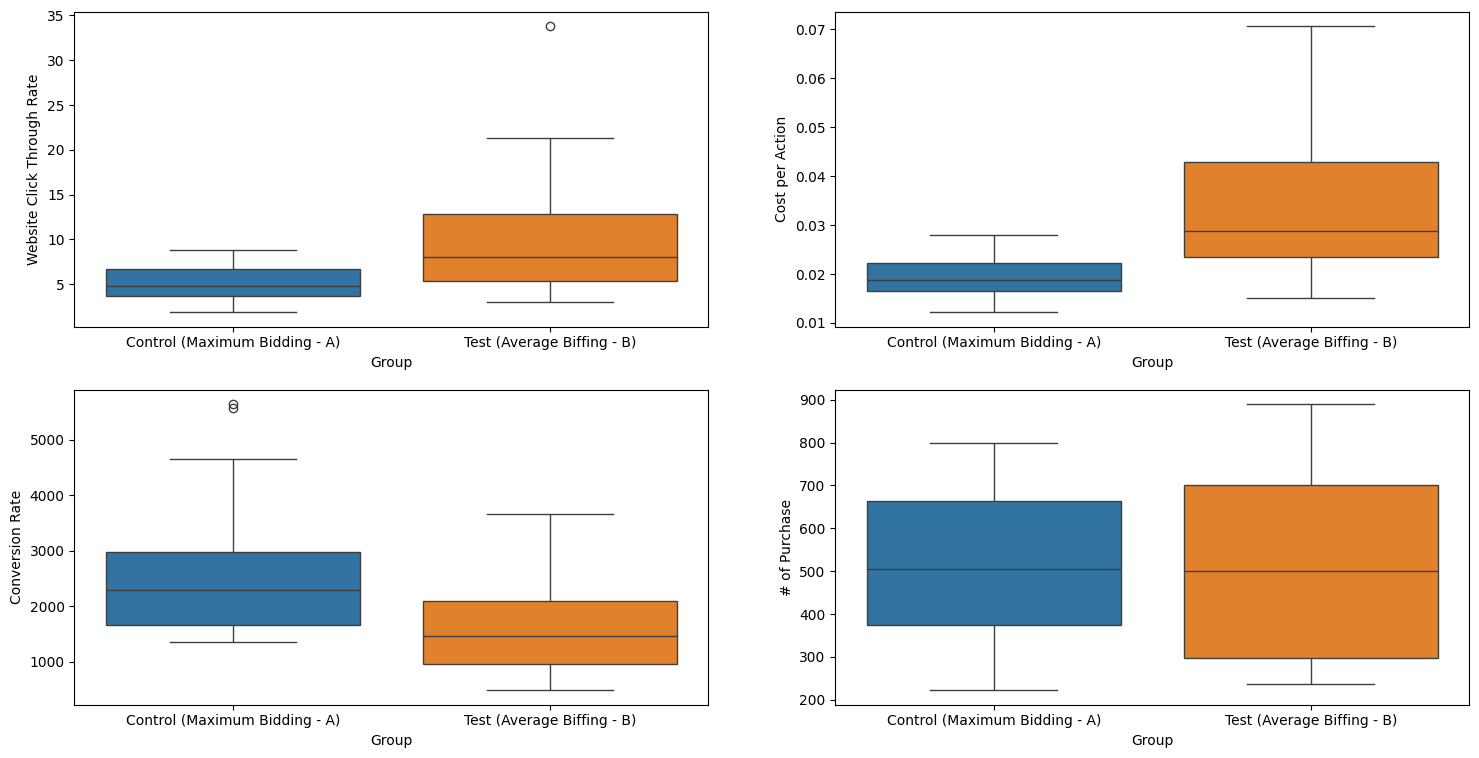

In [37]:
cols = ["Website Click Through Rate","Cost per Action","Conversion Rate","# of Purchase"]
show_boxplot(2,2,[0,1],cols,(18,9))

In [48]:
#TODO : create your dataframe - WE ALREADY DID THIS? - for AB test and print the first 3 rows of it.
AB.head(3)

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,Website Click Through Rate,Number of Action,Cost per Action,Conversion Rate,Group
0,Control Campaign,1.08.2019,2280.0,82702,56930,7016,2290,2159,1819,618,8.483471,96604,0.023602,1376.909920,Control (Maximum Bidding - A)
1,Control Campaign,2.08.2019,1757.0,121040,102513,8110,2033,1841,1219,511,6.700264,134754,0.013039,1661.578298,Control (Maximum Bidding - A)
2,Control Campaign,3.08.2019,2343.0,131711,110862,6508,1737,1549,1134,372,4.941121,143011,0.016383,2197.464659,Control (Maximum Bidding - A)


## 5. T-Test
Since we're doing A/B testing we will perform a type of T-test called "Independent two-sample T-test" which cheks if the means of two independent samples (A and B) are significantly different from each other or if the difference is due to chance.

The name "T-test" might not directly tell us "we’re comparing means," but it tells us how we are doing it — through the T-distribution and T-statistic.

T-test assumes normal distribution, therefore Shapiro-Wilk test is usually performed first to check that. If we see that our data does not follow normal distribution, the results of T-test are likely to be invalid.

### 5.1. Assumption Check
#### 5.1.1. Normal distribution (Shapiro-Wilk test)

 * **H0**: Normal distribution
 * **H1**: Data is not normal = skewed

 Remember: The Shapiro-Wilk test returns two values:
W statistic: A measure of how well the data fits a normal distribution.
p-value: The probability that the sample data is drawn from a normal distribution.

In [25]:
#TODO : Apply the Shapiro-Wilk test on the dataframe for group "A (MaximumBidding)"
#TODO : compute p_value for normality on group A from the AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

My addition
We need to choose which metrics to test with Shapiro-Wilk. We should use critical metrics.

Here’s a complete code snippet that performs the Shapiro-Wilk test on the three key metrics (# of Purchase, Conversion Rate, and Website Click Through Rate) for Group A and visualizes the results using histograms and Q-Q plots.

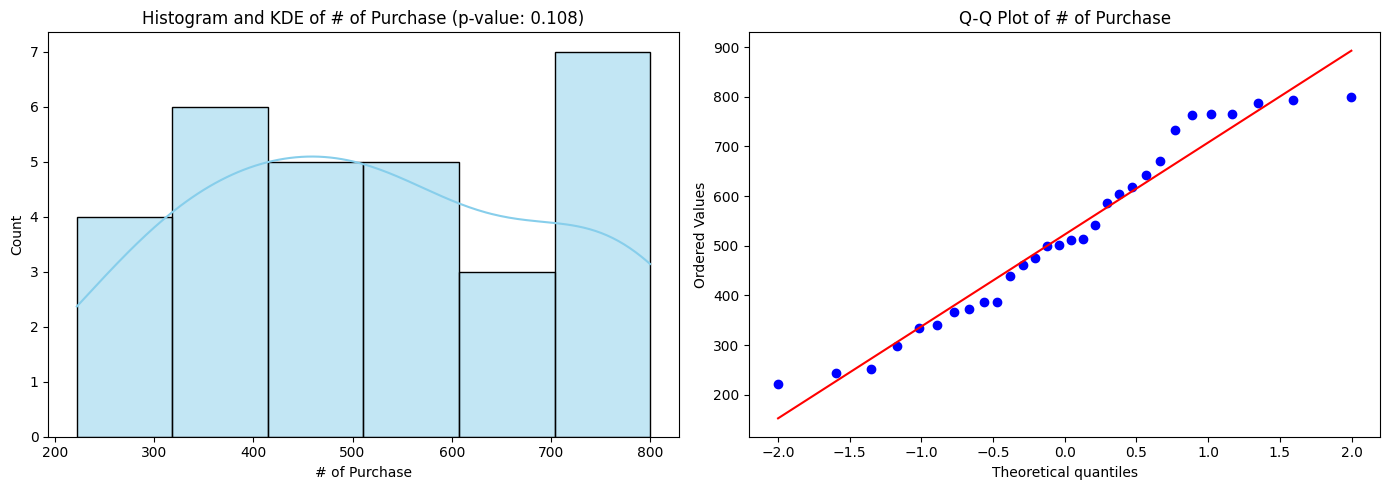

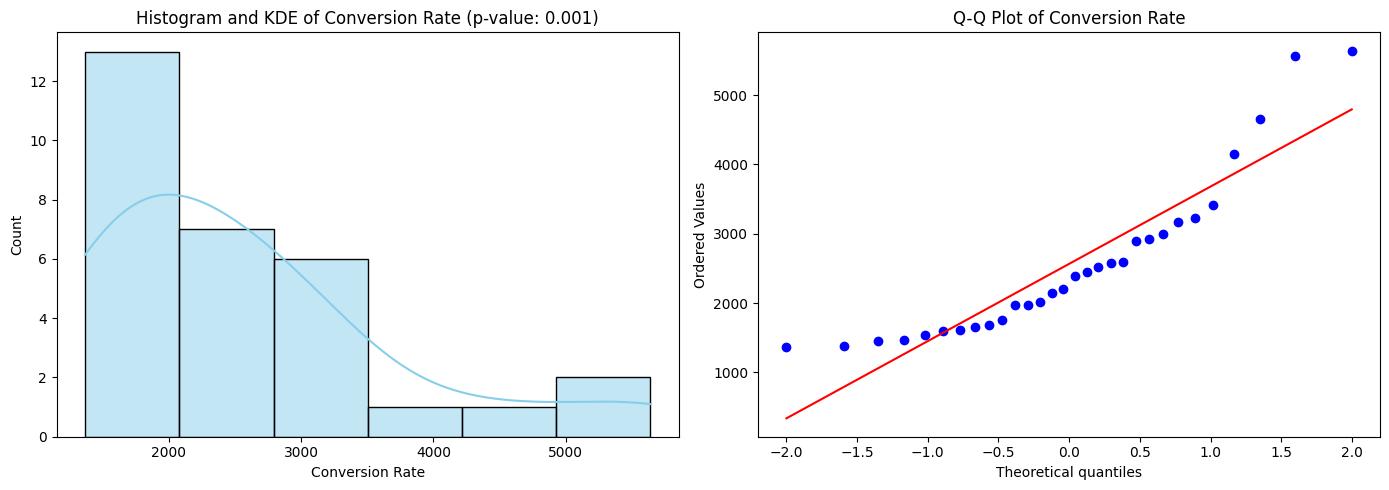

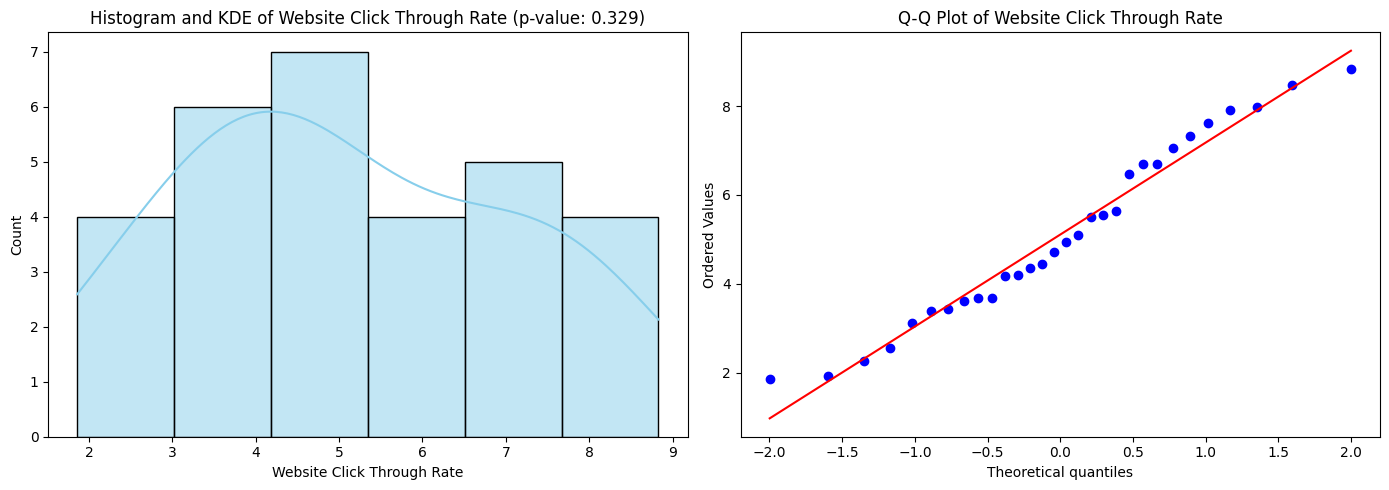

Shapiro-Wilk Test Results for Group A (Maximum Bidding):
                       Metric  p-value                Normality
0               # of Purchase    0.108      Normal Distribution
1             Conversion Rate    0.001  Not Normal Distribution
2  Website Click Through Rate    0.329      Normal Distribution


In [41]:
# Define the metrics to analyze for normality
key_metrics = ['# of Purchase', 'Conversion Rate', 'Website Click Through Rate']

# Create an empty list to store the Shapiro-Wilk test results
shapiro_results_list = []

# Loop through each metric and perform the Shapiro-Wilk test
for metric in key_metrics:
    # Perform the Shapiro-Wilk test
    stat, p_value = shapiro(control[metric])
    # Round the p-value to three decimal places
    p_value_rounded = round(p_value, 3)

    # Determine normality based on p-value
    normality_result = 'Normal Distribution' if p_value >= 0.05 else 'Not Normal Distribution'

    # Append the results to the list as a dictionary
    shapiro_results_list.append({'Metric': metric,
                                 'p-value': p_value_rounded,
                                 'Normality': normality_result})

    # Visualization for each metric
    plt.figure(figsize=(14, 5))

    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(control[metric], kde=True, color='skyblue')
    plt.title(f"Histogram and KDE of {metric} (p-value: {p_value_rounded})")
    plt.xlabel(metric)

    # Q-Q plot
    plt.subplot(1, 2, 2)
    probplot(control[metric], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {metric}")

    plt.tight_layout()
    plt.show()

# Convert the results list into a DataFrame
shapiro_results = pd.DataFrame(shapiro_results_list)

# Display the Shapiro-Wilk test results
print("Shapiro-Wilk Test Results for Group A (Maximum Bidding):")
print(shapiro_results)


Does the HO hypothesis get rejected ? why ?

No, it's normal distribution


What are Q-Q Plots?

What They Show:
Q-Q plots compare the quantiles (points in the data that divide the distribution into equal probabilities) of the sample data against the quantiles of a normal distribution.
If the sample data comes from a normal distribution, the points in the Q-Q plot will fall approximately along a straight diagonal line.

In [27]:
#TODO - DO THE SAME FOR B = TEST

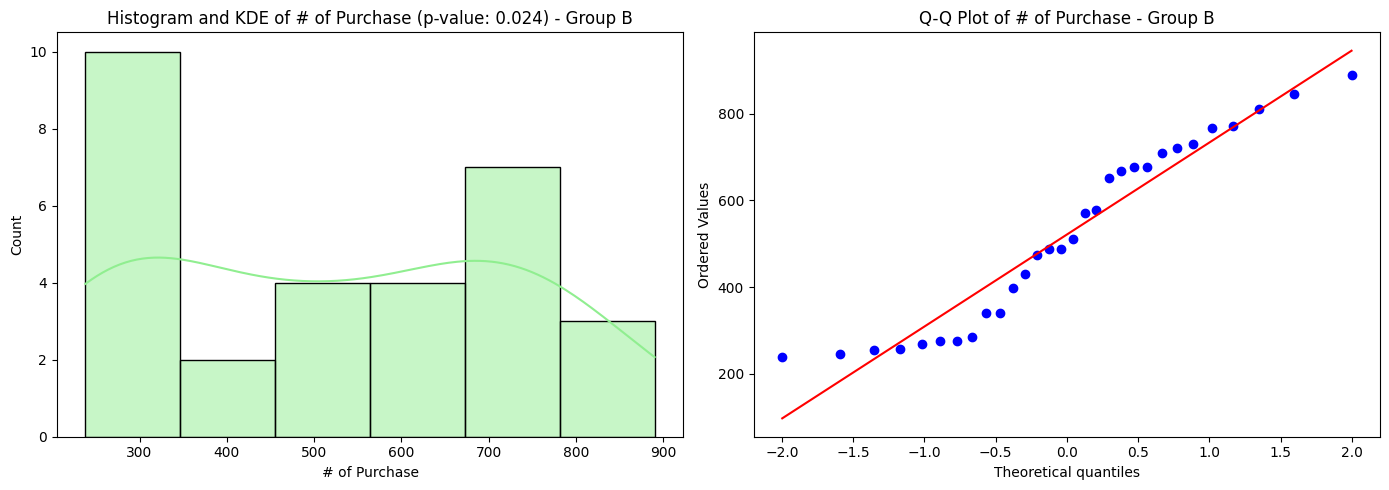

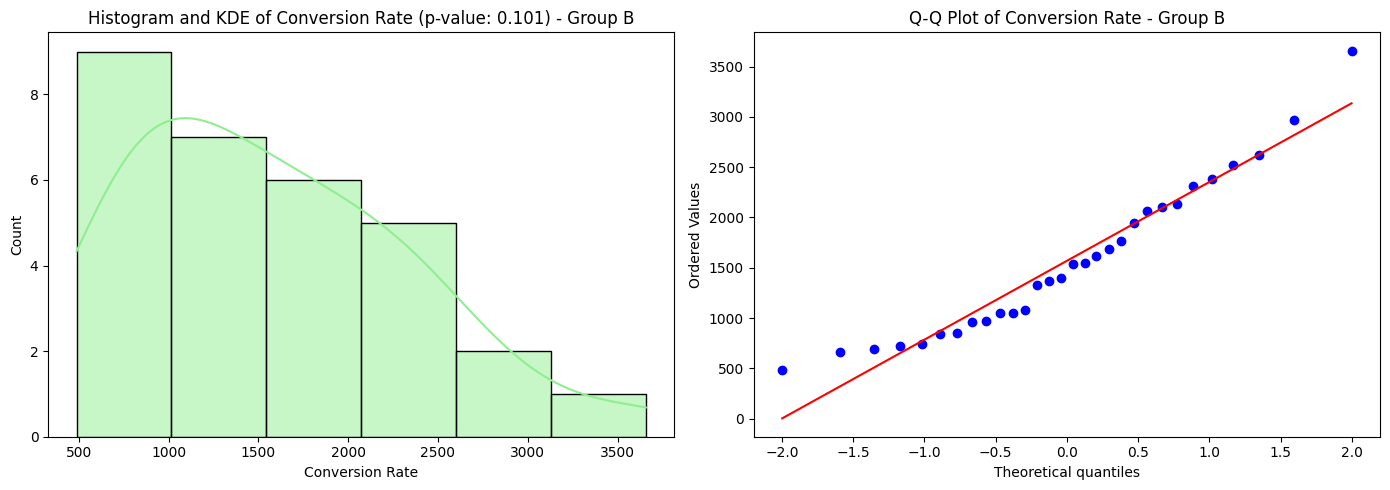

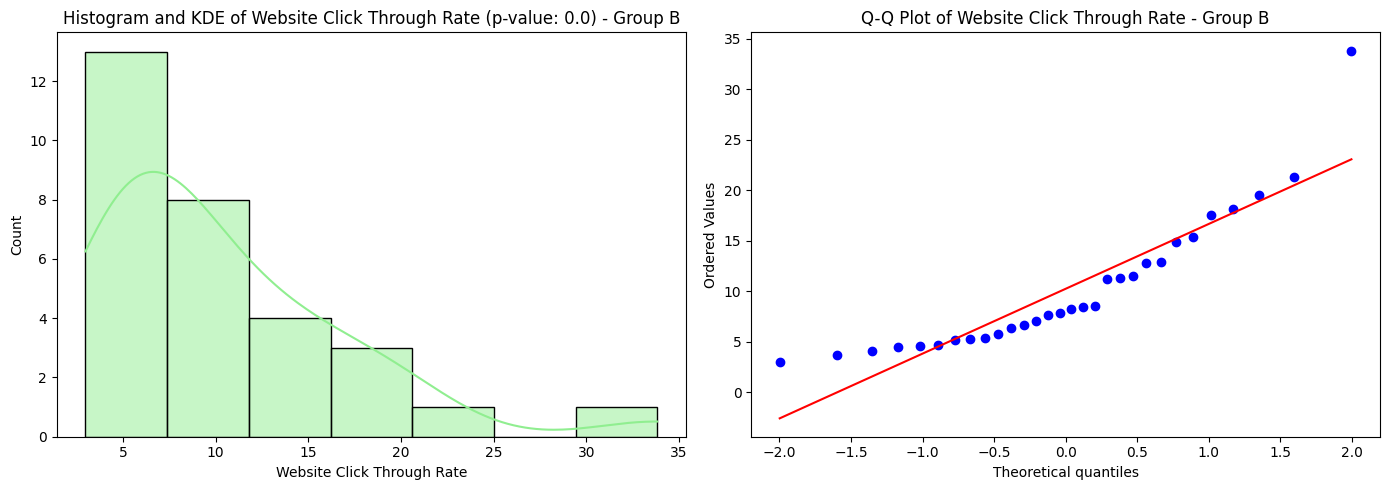

Shapiro-Wilk Test Results for Group B (Test Group):
                       Metric  p-value                Normality
0               # of Purchase    0.024  Not Normal Distribution
1             Conversion Rate    0.101      Normal Distribution
2  Website Click Through Rate    0.000  Not Normal Distribution


In [42]:
# Define the metrics to analyze for normality in Group B
key_metrics = ['# of Purchase', 'Conversion Rate', 'Website Click Through Rate']

# Create an empty list to store the Shapiro-Wilk test results for Group B
shapiro_results_test = []

# Loop through each metric and perform the Shapiro-Wilk test for the Test Group
for metric in key_metrics:
    # Perform the Shapiro-Wilk test
    stat, p_value = shapiro(test[metric])
    # Round the p-value to three decimal places
    p_value_rounded = round(p_value, 3)

    # Determine normality based on p-value
    normality_result = 'Normal Distribution' if p_value >= 0.05 else 'Not Normal Distribution'

    # Append the results to the list as a dictionary
    shapiro_results_test.append({'Metric': metric,
                                 'p-value': p_value_rounded,
                                 'Normality': normality_result})

    # Visualization for each metric
    plt.figure(figsize=(14, 5))

    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(test[metric], kde=True, color='lightgreen')
    plt.title(f"Histogram and KDE of {metric} (p-value: {p_value_rounded}) - Group B")
    plt.xlabel(metric)

    # Q-Q plot
    plt.subplot(1, 2, 2)
    probplot(test[metric], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {metric} - Group B")

    plt.tight_layout()
    plt.show()

# Convert the results list into a DataFrame for Group B
shapiro_results_test_df = pd.DataFrame(shapiro_results_test)

# Display the Shapiro-Wilk test results for Group B
print("Shapiro-Wilk Test Results for Group B (Test Group):")
print(shapiro_results_test_df)


MY addition - something looks not okay with measures for CTR and conversion rate - see the X axis.

Does the HO hypothesis get rejected ? why ?

Yes because data is not normaly distributed

### 5.1.2. Variance Homogeneity Assumption - Another assumption of T-test (oneof parametric tests)
 * **H0** : Variances are homogeneous.
 * **H1** : Variances are not homogeneous.

We want to assess if groups A and B have equal variances, which is a common assumption for various statistical tests :

In [29]:
#TODO : Perform the Levene test for equality of variances on two groups, A and B, from the AB dataframe
# Compute the p_value of the AB dataframe and round it to three decimal places.
# Pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

In [43]:
from scipy.stats import levene

# Perform the Levene test on "# of Purchase" between Group A and Group B
# Filter the AB DataFrame for the two groups
group_A_values = AB[AB['Group'] == 'Control (Maximum Bidding - A)']['# of Purchase']
group_B_values = AB[AB['Group'] == 'Test (Average Biffing - B)']['# of Purchase']

# Perform the Levene test for equality of variances
stat, p_value = levene(group_A_values, group_B_values)

# Round the p-value to three decimal places
p_value_rounded = round(p_value, 3)

# Print the Levene test results
print(f"Levene Test for Equality of Variances: W-statistic = {stat}, p-value = {p_value_rounded}")

# Function to determine if the null hypothesis should be rejected (same as before)
def checkReject(p_value, alpha=0.05):
    if p_value < alpha:
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED (Variances are not equal)')
    else:
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED (Variances are equal)')

# Use the function to check if we can reject the null hypothesis for equality of variances
checkReject(p_value_rounded)


Levene Test for Equality of Variances: W-statistic = 1.6899284344444696, p-value = 0.199
0.199 > alpha(0.05) so >>> H0 CAN'T BE REJECTED (Variances are equal)



Conclude about the variances, are they homogeneous ?

Yes

### 5.1.3. Nonparametric Independent Two-Sample T-Test

- Since the normality of the distribution of the data set in which Average Bidding (Test Group) was measured was rejected, the NonParametric Independent Two-Sample T Test should be applied for the Hypothesis Test.

**Hypothesis:**

 * **H0** : When it comes to Maximum Bidding and Average Bidding, there is no statistically significant difference between the purchasing amounts of the two groups. ($\mu_1 = \mu_2$)

 * **H1** : ... there is a difference ($\mu_1 \neq \mu_2$)

In [51]:
# Average Biddingin (Test Group)
stats.mannwhitneyu(AB["A"], AB["B"])

KeyError: 'Control (Maximum Bidding - A)'

In [ ]:
#TODO : compute the p_value of the AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

In [54]:
from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test on "# of Purchase" between Group A and Group B
# Filter the AB DataFrame for the two groups
group_A_values = AB[AB['Group'] == 'Control (Maximum Bidding - A)']['# of Purchase']
group_B_values = AB[AB['Group'] == 'Test (Average Biffing - B)']['# of Purchase']

# Perform the Mann-Whitney U test for equality of distributions
stat, p_value = mannwhitneyu(group_A_values, group_B_values, alternative='two-sided')

# Round the p-value to three decimal places
p_value_rounded = round(p_value, 3)

# Print the Mann-Whitney U test results
print(f"Mann-Whitney U Test for Equality of Distributions: U-statistic = {stat}, p-value = {p_value_rounded}")

# Function to determine if the null hypothesis should be rejected
def checkReject(p_value, alpha=0.05):
    if p_value < alpha:
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED (Distributions are not equal)')
    else:
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED (Distributions are equal)')

# Use the function to check if we can reject the null hypothesis for equality of distributions
checkReject(p_value_rounded)


Mann-Whitney U Test for Equality of Distributions: U-statistic = 455.0, p-value = 0.947
0.947 > alpha(0.05) so >>> H0 CAN'T BE REJECTED (Distributions are equal)


Should the H0 hypothesis be rejected ? Why ? What can you conclude ?

## 6. Conclusion and Evaluation


##### You should answer the following questions :


**1. How would you define the hypothesis of this A/B test ?**


   
**2. Can we conclude statistically significant results?**

  


**3. Which statistical test did you use, and why?**
   
    
**4. Based on your answer to Question 2, what would be your recommendation to client?**

   

**1. Null Hypothesis (H₀): There is no difference in the conversion rate and purchases between the Maximum Bidding (Group A) and Average Bidding (Group B).
Alternative Hypothesis (H₁): There is a significant difference in the conversion rate and purchases between the two groups.

2. Based on whitney test - there is no significant difference, it may indicate that the new bidding strategy doesn’t have a substantial impact on purchases.

3. We used the Shapiro-Wilk test for normality, Levene’s Test for equality of variances, and the Mann-Whitney U test for comparing distributions because the data did not meet the normality assumption required for parametric tests.

4. Recommendation: Since there is no significant difference between the two bidding strategies in terms of purchases, the client should continue using the existing bidding strategy or conduct further A/B testing on different audience segments or campaign variables before making a final decision.